In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

In [8]:
df_baskets = pd.read_parquet('baskets.parquet')
df_coupons = pd.read_parquet('coupons.parquet')
#df_baskets = df_baskets[df_baskets["customer"]<2000]
#df_coupons = df_coupons[df_coupons["customer"]<2000]
df_coupons

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44999995,89,99999,62,40
44999996,89,99999,110,10
44999997,89,99999,37,40
44999998,89,99999,155,25


(68841598, 4)

In [12]:
training_week_1 = df_baskets['week'].max()-3 #86 
training_week_2 = df_baskets['week'].max()-2 #87
training_week_3 = df_baskets['week'].max()-1 #88
validation_week_1 = df_baskets['week'].max()-2 #87
validation_week_2 = df_baskets['week'].max()-1 #88
validation_week_3 = df_baskets['week'].max #89
test_week = df_baskets['week'].max()+1
target_customers = list(range(2000))
target_products = list(range(250))

In [13]:
def buildTarget(df_baskets, week):
    df_baskets_week = df_baskets[df_baskets["week"] == week][["week", "customer", "product"]].reset_index(drop=True)
    df_baskets_week["y"] = 1

    df = pd.DataFrame({"week": week, "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),})
    df = df.merge(df_baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

baselineTarget = buildTarget(df_baskets, validation_week_1)
baselineTarget.head()

,week,customer,product,y
0,87,0,0,0
1,87,0,1,0
2,87,0,2,0
3,87,0,3,0
4,87,0,4,0


In [14]:
def frequencyFeature(df_baskets, week_start, week_end, feature_name):
    df_baskets_subset = df_baskets[(df_baskets["week"] >= week_start) & (df_baskets["week"] <= week_end)]
    
    purchaseFrequency = (
        (df_baskets_subset.groupby(["customer", "product"])[["week"]].count()/ df_baskets_subset.week.nunique())
        .rename(columns={"week": feature_name})
        .reset_index())

    return purchaseFrequency

def build_target(df_baskets, week):
    df_baskets_week = df_baskets[df_baskets["week"] == week][["week", "customer", "product"]].reset_index(drop=True)
    df_baskets_week["y"] = 1
    df = pd.DataFrame({"week": week,"customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers)})
    df = df.merge(df_baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [15]:
frequencyFeature(df_baskets, -1, training_week_1 - 1, "Probability_Feature")

,customer,product,Probability_Feature
0,0,4,0.093023
1,0,11,0.104651
2,0,15,0.011628
3,0,16,0.034884
4,0,37,0.011628
...,...,...,...
7000421,99999,226,0.290698
7000422,99999,231,0.127907
7000423,99999,234,0.081395
7000424,99999,243,0.011628


In [16]:
def baseTable(df_baskets, week):
    feature1 = frequencyFeature(df_baskets, -1, week - 1, "range_full")
    feature2 = frequencyFeature(df_baskets, week - 30, week - 1, "range_l30")
    feature3 = frequencyFeature(df_baskets, week - 5, week - 1, "range_l5")
    y = build_target(df_baskets, week)
    baseTableComplete = (
        y.merge(feature1, on=["customer", "product"], how="left")
        .merge(feature2, on=["customer", "product"], how="left")
        .merge(feature3, on=["customer", "product"], how="left")
        .fillna(0)
    )
    return baseTableComplete

In [ ]:
baseTable(df_baskets, training_week_1)

# Training: Train model (week<87)

In [17]:
baseTableTrain = baseTable(df_baskets, training_week_1)
y = baseTableTrain["y"].values
xs = baseTableTrain[["range_full", "range_l30", "range_l5"]].values

In [18]:
log_reg = sklearn.linear_model.LogisticRegression().fit(xs, y)
log_reg.intercept_, log_reg.coef_

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([-4.48924046]), array([[10.56807021,  0.51703428, -1.00420638]]))

In [19]:
baseTableTrain["probability"] = log_reg.predict_proba(xs)[:, 1]

#Binary cross entropy loss 
def score_yp(y, p): # 
    return sklearn.metrics.log_loss(y, p)

score_yp(
    baseTableTrain["y"].values,
    baseTableTrain["probability"].values,
)

0.0898401396422278

# Validation performance week 87

In [23]:
baseTableValidation = baseTable(df_baskets, validation_week_1)
xs_validation = baseTableValidation[
    ["range_full", "range_l30", "range_l5"]
].values
baseTableValidation["probability"] = log_reg.predict_proba(xs_validation)[:, 1]

In [24]:
score_yp(
    baseTableValidation["y"].values,
    baseTableValidation["probability"].values,
)

0.0902495991387123

# Training: Train model (week<88)

In [29]:
baseTableTrain_1 = baseTable(df_baskets, training_week_2)
y = baseTableTrain_1["y"].values
xs = baseTableTrain_1[["range_full", "range_l30", "range_l5"]].values

In [30]:
log_reg = sklearn.linear_model.LogisticRegression().fit(xs, y)
log_reg.intercept_, log_reg.coef_

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([-4.48408224]), array([[10.66862196,  0.27786822, -0.81178315]]))

In [31]:
baseTableTrain_1["probability"] = log_reg.predict_proba(xs)[:, 1]

#Binary cross entropy loss 
def score_yp(y, p): # 
    return sklearn.metrics.log_loss(y, p)

score_yp(
    baseTableTrain_1["y"].values,
    baseTableTrain_1["probability"].values,
)

0.09023967667716135

# Validation performance week 88

In [32]:
baseTableValidation_1 = baseTable(df_baskets, validation_week_2)
xs_validation_1 = baseTableValidation_1[
    ["range_full", "range_l30", "range_l5"]
].values
baseTableValidation_1["probability"] = log_reg.predict_proba(xs_validation)[:, 1]

In [33]:
score_yp(
    baseTableValidation_1["y"].values,
    baseTableValidation_1["probability"].values,
)

0.09009893803570214

# Training: Train model (week<89)

In [34]:
baseTableTrain_2 = baseTable(df_baskets, training_week_3)
y = baseTableTrain_2["y"].values
xs = baseTableTrain_2[["range_full", "range_l30", "range_l5"]].values

In [35]:
log_reg = sklearn.linear_model.LogisticRegression().fit(xs, y)
log_reg.intercept_, log_reg.coef_

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([-4.48467422]), array([[10.74077981,  0.31211633, -0.98101563]]))

In [36]:
baseTableTrain_2["probability"] = log_reg.predict_proba(xs)[:, 1]

#Binary cross entropy loss 
def score_yp(y, p): 
    return sklearn.metrics.log_loss(y, p)

score_yp(
    baseTableTrain_2["y"].values,
    baseTableTrain_2["probability"].values,
)

0.09008076478450777

# Validation performance week 89

In [38]:
baseTableValidation_2 = baseTable(df_baskets, validation_week_2)
xs_validation_2 = baseTableValidation_2[
    ["range_full", "range_l30", "range_l5"]
].values
baseTableValidation_2["probability"] = log_reg.predict_proba(xs_validation)[:, 1]

In [39]:
score_yp(
    baseTableValidation_2["y"].values,
    baseTableValidation_2["probability"].values,
)

0.09010867602437822

# Final Result week 90

In [43]:
baseTableFinal = baseTable(df_baskets, test_week)

In [44]:
xs_test = baseTableFinal[["range_full", "range_l30", "range_l5"]].values
baseTableFinal["probability"] = log_reg.predict_proba(xs_test)[:, 1]
baseTableFinal

,week,customer,product,y,range_full,range_l30,range_l5,probability
0,90,0,0,0,0.000000,0.000000,0.0,0.011155
1,90,0,1,0,0.000000,0.000000,0.0,0.011155
2,90,0,2,0,0.000000,0.000000,0.0,0.011155
3,90,0,3,0,0.000000,0.000000,0.0,0.011155
4,90,0,4,0,0.088889,0.066667,0.0,0.029054
...,...,...,...,...,...,...,...,...
499995,90,1999,245,0,0.133333,0.166667,0.2,0.039288
499996,90,1999,246,0,0.000000,0.000000,0.0,0.011155
499997,90,1999,247,0,0.000000,0.000000,0.0,0.011155
499998,90,1999,248,0,0.000000,0.000000,0.0,0.011155


# Visualization

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\Zinedine\Anaconda3\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

[Text(279.0, 142.69500000000002, 'X[1] <= 0.083\nentropy = 0.197\nsamples = 315632\nvalue = [484742, 15258]'),
 Text(139.5, 101.92500000000001, 'X[0] <= 0.017\nentropy = 0.061\nsamples = 283892\nvalue = [446494, 3226]'),
 Text(69.75, 61.155, 'X[0] <= 0.006\nentropy = 0.023\nsamples = 251126\nvalue = [396726, 902]'),
 Text(34.875, 20.38499999999999, 'entropy = 0.014\nsamples = 226896\nvalue = [358722, 460]'),
 Text(104.625, 20.38499999999999, 'entropy = 0.091\nsamples = 24230\nvalue = [38004, 442]'),
 Text(209.25, 61.155, 'X[1] <= 0.05\nentropy = 0.263\nsamples = 32766\nvalue = [49768, 2324]'),
 Text(174.375, 20.38499999999999, 'entropy = 0.239\nsamples = 22609\nvalue = [34468, 1409]'),
 Text(244.125, 20.38499999999999, 'entropy = 0.313\nsamples = 10157\nvalue = [15300, 915]'),
 Text(418.5, 101.92500000000001, 'X[2] <= 0.5\nentropy = 0.794\nsamples = 31740\nvalue = [38248, 12032]'),
 Text(348.75, 61.155, 'X[0] <= 0.236\nentropy = 0.719\nsamples = 27038\nvalue = [34392, 8507]'),
 Text(31

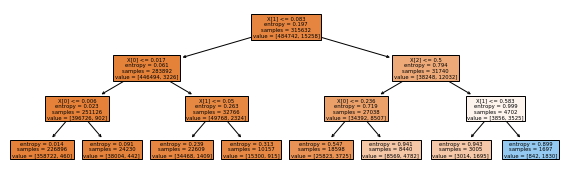

In [42]:
clf = RandomForestClassifier(n_estimators=20, 
                             random_state=0, 
                             criterion='entropy',
                             max_depth=3)

y = baseTableTrain_1["y"].values
X = baseTableTrain_1[["range_full", "range_l30", "range_l5"]].values

clf = clf.fit(X, y)
clf.estimators_

plt.figure(figsize=(10,3))
tree.plot_tree(clf.estimators_[10], filled=True)

# Distribution